# Unsupervised Anomaly Detection using Vector Embeddings from Fine-Tuned DNS <U>doc2vec model</U>
1/22/2025, Dave Sisk, https://github.com/davidcsisk, https://www.linkedin.com/in/davesisk-doctordatabase/

This is a continuation of the prior research. In this notebook, we are leveraging the <u>Isolation Forest</u> algorithm to perform unsupervised training of an anomaly detection model, using text <u>vector embeddings</u> as the input. In this working example, we will use a doc2vec model that has been trained with the full contents of Wikipedia and then fine-tuned with DNS log data from secrepo.com.

In [11]:
### Uncomment and run the line below if this is the first time executing this notebook. Package installs in requirements.txt.
#! python -m venv venv
#! powershell venv\Scripts\Activate.ps1
#! pip install pandas 
#! pip install matplotlib
#! pip install scikit-learn
#! pip install gensim
#! pip install nltk
#import nltk
#nltk.download('punkt_tab')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import word_tokenize
from gensim.models import Doc2Vec

You can find the doc2vec model fine-tuning process here: 
https://github.com/davidcsisk/vector-search-with-security-logs/blob/main/fine-tune-doc2vec-model_dns-logs.ipynb

You can find the initial doc2vec training process on full wikipedia contents here: 
https://github.com/davidcsisk/vector-search-with-security-logs/blob/main/doc2vec-model-build_wikipedia-full-content.ipynb 

In [2]:
# Load pre-trained fine-tuned doc2vec model...this can take a minute or two
#model_dbow = Doc2Vec.load('doc2vec_wikipedia_dbow.model')
model_dbow = Doc2Vec.load('doc2vec_wikipedia_dbow_fine-tuned-on-dns.model')

#model_dm = Doc2Vec.load('doc2vec_wikipedia_dm.model')
model_dm = Doc2Vec.load('doc2vec_wikipedia_dm_fine-tuned-on-dns.model')

In [3]:
# Do a test inference to see if the vector embedding looks like something we'd expect...so far, so good
new_doc = word_tokenize('UDP    www.example.com   IN   A    93.184.216.34 False')
# Try both
print('sample vector DBOW: ', model_dbow.infer_vector(new_doc))
print('sample vector DM: ', model_dm.infer_vector(new_doc))


sample vector DBOW:  [-6.6047912e-03 -4.0111127e-03 -1.6583990e-03 -1.4481047e-03
  2.8065527e-03  2.6297714e-03  8.1194576e-04  2.3542086e-03
 -2.9161044e-03  5.1545124e-03 -1.1701375e-03 -4.5725875e-04
  3.3100895e-03  7.1008634e-03 -1.5917163e-03 -7.2671252e-04
 -1.3605825e-03  6.9666561e-04 -5.5461875e-03 -5.0081215e-03
  1.8206630e-03 -5.5205805e-05  2.2947174e-03  3.8808763e-03
  2.0987638e-03 -2.5491635e-03  2.5321560e-03  1.0933834e-03
 -7.8888126e-03 -2.4593982e-03  5.2140700e-03  6.0413550e-03
  1.7021215e-03 -5.8288034e-03 -3.0002292e-04 -6.8366830e-04
  5.2638166e-03  2.8335638e-03  1.6177485e-03 -1.8073432e-03
  9.0477418e-04 -3.1590732e-03 -3.8256296e-03 -9.8618958e-04
  2.0130442e-03  4.7760489e-03 -2.9963928e-03 -5.0325645e-03
 -1.7734466e-03  6.2926244e-03 -5.1132548e-03 -6.4098118e-03
 -9.0516200e-03 -3.1198338e-03  2.6185620e-03  5.8623492e-03
 -5.1099379e-03 -2.0224343e-03 -2.8277086e-03 -7.2472831e-05
 -9.8648469e-04  4.6945140e-03  1.3263765e-03  2.1663199e-03
  1

In [4]:
# We'll use the fabricated mixed proxy logs with known 950 benign log entries and 50 malicious log entries 
# Our goal is to see if we can get them accurately classified into that 950 benign + 50 malicious
# Read the log data into a dataframe, and drop the columns we don't need for this exercise, and 
# extract the return code to use in validating the eventual output
df = pd.read_csv('dns-log_test-data.csv')
#df = df.drop(['IP Address', 'Timestamp'], axis=1)  # We don't need IP nor timestamp for this task
#df['return_code'] = df['Log Entry'].str.split().str[3]

df.sample(3)

,protocol,resolved_address,class,query_type,response,rejected
17226,udp,www.apple.com,C_INTERNET,A,-,F
18833,udp,safebrowsing.clients.google.com,C_INTERNET,A,-,F
8645,udp,autodiscover.west.exch028.serverdata.net,C_INTERNET,A,-,F


In [5]:
# Preprocess a single row by concatenating all columns and tokenizing
def preprocess_dns_row(row):
    concatenated = ' '.join(map(str, row))  # Combine all column values as a single string
    tokens = concatenated.lower().split()  # Tokenize and convert to lowercase
    return tokens

# Create a new column for TaggedDocument objects in the DataFrame
df['TaggedDocument'] = [
    TaggedDocument(words=preprocess_dns_row(row), tags=[f"dns_{i}"])
    for i, row in df.iterrows()
]

In [6]:
# We'll use the pre-trained doc2vec model to calculate vector embeddings for these logs

# Apply infer_vector by extracting words from TaggedDocument
df['embedding_dbow'] = df['TaggedDocument'].apply(lambda doc: model_dbow.infer_vector(doc.words))
df['embedding_dm'] = df['TaggedDocument'].apply(lambda doc: model_dm.infer_vector(doc.words))

df.sample(3)

,protocol,resolved_address,class,query_type,response,rejected,TaggedDocument,embedding_dbow,embedding_dm
20794,udp,fs-1.one.ubuntu.com,C_INTERNET,A,NXDOMAIN,F,"([udp, fs-1.one.ubuntu.com, c_internet, a, nxd...","[-0.007769933, -0.0054057557, -0.0046659317, 0...","[0.0015788043, -0.0007123841, -0.0004836488, 0..."
9644,udp,tools.google.com,C_INTERNET,A,-,F,"([udp, tools.google.com, c_internet, a, -, f],...","[-0.0049385065, -0.006350809, -0.004413053, 0....","[0.0042933286, -0.0015426665, 0.0007903721, 0...."
12855,udp,WPAD,C_INTERNET,NB,-,F,"([udp, wpad, c_internet, nb, -, f], [dns_12855])","[-0.007192322, -0.010743941, -0.0077361893, 0....","[0.0005542971, -0.0038421822, -0.0027267039, 0..."


## Train Isolation Forest unsupervised model using the vector embeddings
We are doing semantic anomaly detection in this exercise.  The vector embeddings try to capture what the text content <i>means</i>, so applying isolation forest algorithm those numeric values will give us anomalies that <i>have a different meaning</i> than the norm.  The accuracy of this depends on how good the vector embeddings captured the meaning of the text content.

In [7]:
## DBOW
# Define a model object with the Isolation Forest algorithm
iforest_dbow_model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding_dbow'].values)

# Fit the data to the model
iforest_dbow_model.fit(X)

# Display parameter values that were used
iforest_dbow_model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [8]:
## DM
# Define a model object with the Isolation Forest algorithm
iforest_dm_model=IsolationForest(n_estimators=100,max_samples=1000,contamination='auto',random_state=96)

# Convert the embedding column to a numpy array for input to IsolationForest...it's a little nit-picky here
X = np.vstack(df['embedding_dm'].values)

# Fit the data to the model
iforest_dm_model.fit(X)

# Display parameter values that were used
iforest_dm_model.get_params()

{'bootstrap': False,
 'contamination': 'auto',
 'max_features': 1.0,
 'max_samples': 1000,
 'n_estimators': 100,
 'n_jobs': None,
 'random_state': 96,
 'verbose': 0,
 'warm_start': False}

In [9]:
## DBOW
# Add a column to the DF for scores from the model's decision_function
df['raw_score_dbow'] = iforest_dbow_model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score_dbow'] = iforest_dbow_model.predict(X)

## DM
# Add a column to the DF for scores from the model's decision_function
df['raw_score_dm'] = iforest_dm_model.decision_function(X)

# Add a column to the DF for the anomaly flag from the model's predict function...-1 indicates anomaly
df['anomaly_score_dm'] = iforest_dm_model.predict(X)


In [10]:
# Display the data with the columns added
df.sample(3)

,protocol,resolved_address,class,query_type,response,rejected,TaggedDocument,embedding_dbow,embedding_dm,raw_score_dbow,anomaly_score_dbow,raw_score_dm,anomaly_score_dm
17418,udp,creativecommons.org.stayonline.net,C_INTERNET,A,-,F,"([udp, creativecommons.org.stayonline.net, c_i...","[-0.009338665, -0.0075488226, -0.003594402, 0....","[0.0010402156, -0.005598323, 0.002974322, 0.00...",-0.097818,-1,0.018029,1
16168,udp,www.dokuwiki.org,C_INTERNET,AAAA,-,F,"([udp, www.dokuwiki.org, c_internet, aaaa, -, ...","[-0.00827896, -0.008399038, -0.006739094, 0.00...","[0.002147756, -0.00023775885, -0.0005696652, 0...",-0.079428,-1,0.040180,1
6900,udp,teredo.ipv6.microsoft.com,C_INTERNET,A,-,F,"([udp, teredo.ipv6.microsoft.com, c_internet, ...","[-0.00691682, -0.0069213994, -0.0024088696, 0....","[-0.0004695879, -0.004910969, -0.0009082686, 0...",-0.078587,-1,0.087070,1


In [11]:
# The outliers have anomaly_score = -1 
print("DBOW: ", df['anomaly_score_dbow'].value_counts())
print("DM: ", df['anomaly_score_dm'].value_counts())

DBOW:  anomaly_score_dbow
-1    27935
Name: count, dtype: int64
DM:  anomaly_score_dm
 1    27374
-1      561
Name: count, dtype: int64


Interestingly enough, the DBOW (Distributed Bag of Words) model flagged every record as an anomaly...we saw similar behavior with generated proxy logs before the DBOW model was fine-tuned. The DM (Distributed Memory) model seems to be producing a more believable result, however. Perhaps this is why DM is the default algorithm, eh? Let's examine plots to gain some insight...

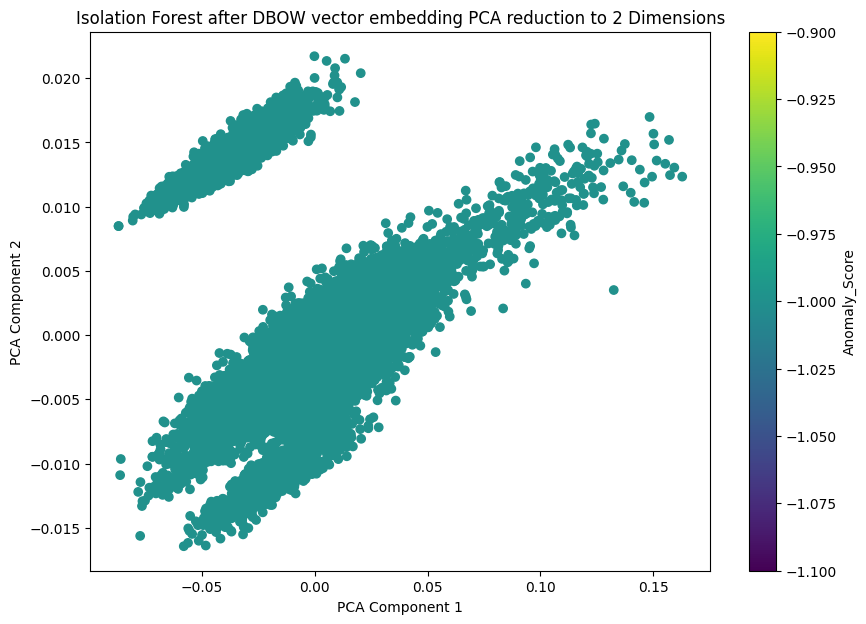

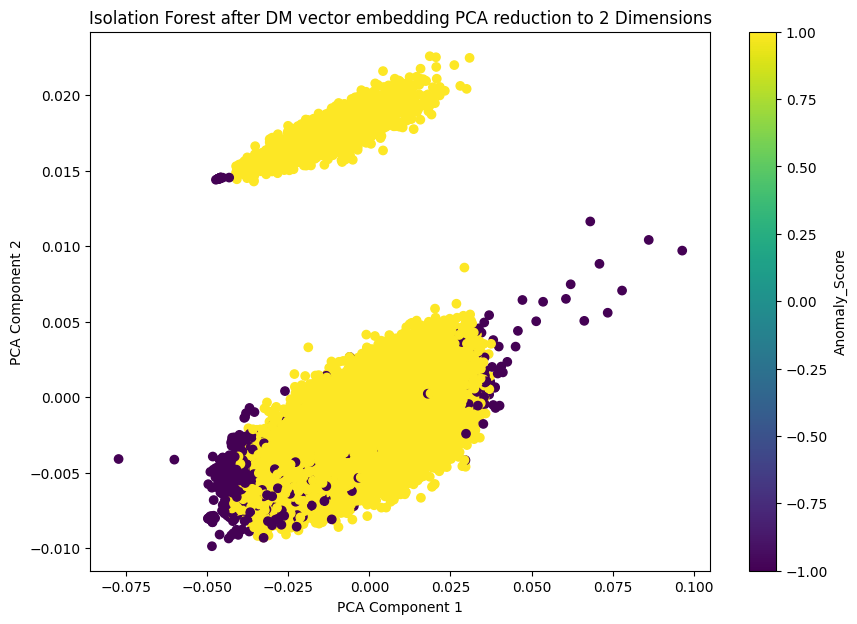

In [12]:
# Plot the results after applying PCA to the vector embeddings...color indicates the anomaly score.
# This is a bit like plotting two things to try to understand how/why they align/not...the dark colors are
# the samples that were flagged as anomalies.

## DBOW
# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings_dbow = df['embedding_dbow'].tolist()
reduced_embeddings_dbow = pca.fit_transform(embeddings_dbow)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings_dbow[:, 0], reduced_embeddings_dbow[:, 1], c=df['anomaly_score_dbow'], cmap='viridis', marker='o')
plt.title('Isolation Forest after DBOW vector embedding PCA reduction to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()

## DM
# Reduce the 384 dimension vector embeddings to 2 dimensions using PCA
pca = PCA(n_components=2)
embeddings_dm = df['embedding_dm'].tolist()
reduced_embeddings_dm = pca.fit_transform(embeddings_dm)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(reduced_embeddings_dm[:, 0], reduced_embeddings_dm[:, 1], c=df['anomaly_score_dm'], cmap='viridis', marker='o')
plt.title('Isolation Forest after DM vector embedding PCA reduction to 2 Dimensions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Anomaly_Score')
plt.show()


# Judging from the plot, this appears to have done a decent job with the anomaly detection

The plots from DBOW and DM look somewhat similar, ignoring orientation.  I don't know why DBOW would flag every entry as anomaly...it almost seems as though it's ignoring the fine-tuning. Again, the DM plot looks more believable, so I believe we can ignore DBOW going forward and try to leverage DM.  We need to dig into why these records were flagged as anomalies. 

In [13]:
df[df['anomaly_score_dm'] == -1].sample(5)

,protocol,resolved_address,class,query_type,response,rejected,TaggedDocument,embedding_dbow,embedding_dm,raw_score_dbow,anomaly_score_dbow,raw_score_dm,anomaly_score_dm
26545,udp,WWW.COMODO.COM,C_INTERNET,NB,-,F,"([udp, www.comodo.com, c_internet, nb, -, f], ...","[-0.0066563855, -0.009703169, -0.0073749423, -...","[0.0006173289, -5.4383992e-05, -0.0019574247, ...",-0.093043,-1,-0.018857,-1
515,udp,www.google.com,C_INTERNET,A,NOERROR,F,"([udp, www.google.com, c_internet, a, noerror,...","[-0.011872785, -0.012819357, -0.0054083597, 0....","[-0.0010349654, -0.00042441307, 0.0022134508, ...",-0.124353,-1,-0.006177,-1
20839,udp,macromedia,C_INTERNET,A,-,F,"([udp, macromedia, c_internet, a, -, f], [dns_...","[-0.010414528, -0.011752149, -0.0042209034, 0....","[0.004188034, -0.0035722002, 0.00056659756, 0....",-0.080175,-1,-0.004711,-1
25524,udp,r._dns-sd._udp.0.202.168.192.in-addr.arpa,C_INTERNET,PTR,REFUSED,T,"([udp, r._dns-sd._udp.0.202.168.192.in-addr.ar...","[-0.01741857, -0.017982474, -0.01187882, 0.002...","[-0.0017836298, 0.001869647, 0.0012710275, 0.0...",-0.097729,-1,-0.026387,-1
6149,udp,r._dns-sd._udp.0.6.16.172.in-addr.arpa,C_INTERNET,PTR,-,F,"([udp, r._dns-sd._udp.0.6.16.172.in-addr.arpa,...","[-0.007142241, -0.006936907, -0.0035425115, 0....","[0.0063938084, -0.007686058, 0.0010555645, 0.0...",-0.101377,-1,-0.002906,-1


Note:  Still a work in progress...